# Transformer Application for Image Data

# I. Image Classifier from Scratch

# 1. Import libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from modules.data_prep import create_dataloaders, PatchEmbedding
from modules.evaluation import show_losses_and_accs
from modules.prediction import pred_and_plot_image
from modules.others import plot_an_image

from modules.others import set_seeds
from modules.model import TransformerEncoderBlock, ViTBlock
from modules.train_prep import train

!pip install torchinfo
from torchinfo import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# !rm -rf /content/data1000
!tar -xzvf /content/flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

# 2. Create DataLoaders

In [ ]:
# Setup parameters to train and test images
path = "/content/flower_photos"
IMG_SIZE = 224 # image siz
BATCH_SIZE = 32 # batch size

# Create transform pipeline manually
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(root_path=path, transform=image_transforms, batch_size=BATCH_SIZE)

print(f"Manually created transforms: {image_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x7ba7e7d9bb20>,
 <torch.utils.data.dataloader.DataLoader at 0x7ba7e813fd30>)

# 3. Plot an image

In [ ]:
# Visualize a image
plot_an_image(train_dataloader, class_names)

# 3. Preprocess the data

In [ ]:
set_seeds()

# 1. Set variable
patch_size = 16

# 2. Print shape of original image tensor
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0228, -0.0102, -0.0321,  ...,  0.0136, -0.0051,  0.0047],
         [-0.0228, -0.0102, -0.0321,  ...,  0.0136, -0.0051,  0.0047],
         ...,
         [-0.0228, -0.0102, -0.0321,  ...,  0.0136, -0.0051,  0.0047],
         [-0.0228, -0.0102, -0.0321,  ...,  0.0136, -0.0051,  0.0047],
         [-0.0228, -0.0102, -0.0321,  ...,  0.0136, -0.0051,  0.0047]]],
       grad_fn=<CatBackward0>)


# 4. Show the model

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block, input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (mha_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# 5. Train the model

In [ ]:
# Create the model
vit = ViTBlock(num_classes=len(class_names))

# Setup the optimizer to optimize
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, # ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values Training & Fine-tuning)
                             weight_decay=0.3) # ViT-* ImageNet-1k

# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9293 | train_acc: 0.2116 | test_loss: 1.6360 | test_acc: 0.2316
Epoch: 2 | train_loss: 1.6311 | train_acc: 0.2270 | test_loss: 1.6576 | test_acc: 0.1689
Epoch: 3 | train_loss: 1.6188 | train_acc: 0.2414 | test_loss: 1.6087 | test_acc: 0.2316
Epoch: 4 | train_loss: 1.6098 | train_acc: 0.2364 | test_loss: 1.6024 | test_acc: 0.2316
Epoch: 5 | train_loss: 1.6034 | train_acc: 0.2355 | test_loss: 1.6032 | test_acc: 0.2316
Epoch: 6 | train_loss: 1.6011 | train_acc: 0.2485 | test_loss: 1.6032 | test_acc: 0.2316
Epoch: 7 | train_loss: 1.6017 | train_acc: 0.2478 | test_loss: 1.6035 | test_acc: 0.2316
Epoch: 8 | train_loss: 1.6024 | train_acc: 0.2482 | test_loss: 1.6041 | test_acc: 0.2316
Epoch: 9 | train_loss: 1.6034 | train_acc: 0.2482 | test_loss: 1.6041 | test_acc: 0.2316
Epoch: 10 | train_loss: 1.6030 | train_acc: 0.2478 | test_loss: 1.6046 | test_acc: 0.2316


# 6. Evaluation

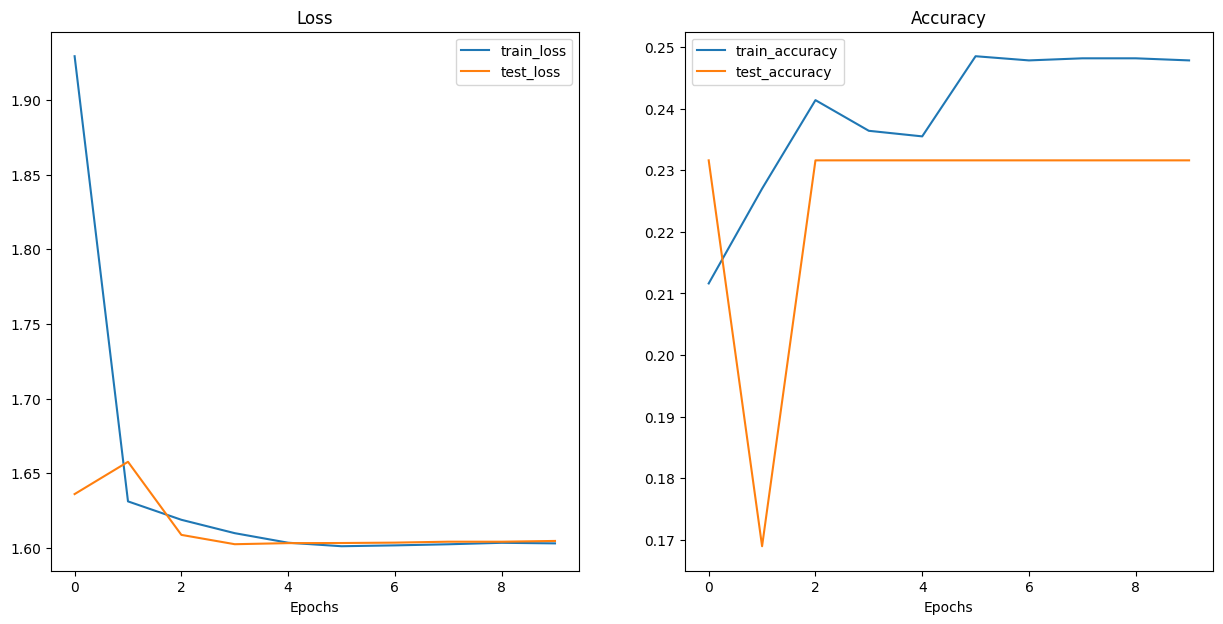

In [ ]:
# Plot the losses and accs
show_losses_and_accs(results)

# 7. Predict the results

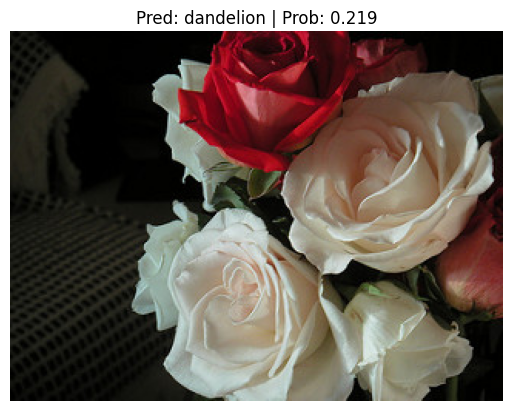

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on an image
image_path = "/content/flower_photos/roses/102501987_3cdb8e5394_n.jpg"
pred_and_plot_image(model=vit, image_path=image_path, class_names=class_names)

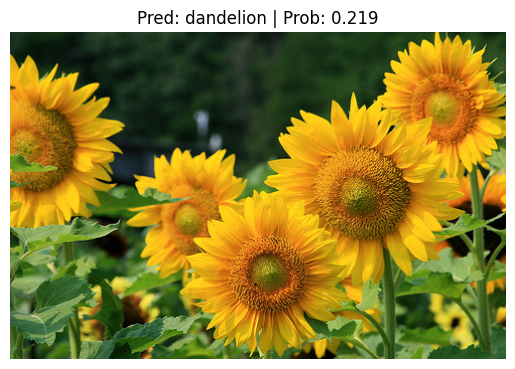

In [ ]:
# Predict on an image
image_path_1 = "/content/flower_photos/sunflowers/1008566138_6927679c8a.jpg"
pred_and_plot_image(model=vit, image_path=image_path_1, class_names=class_names)